# Visualize Monitor Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget


# === CONFIGURATION ===
# --- Step 1: Set the name of your .txt file here ---
filename = "../data/output.txt"  # <--- CHANGE THIS

collumn_names = ['ax', 'ay', 'az', 'state', 'step_detected']
df = pd.read_csv(filename, header=None, names=collumn_names)
# === ADD THE NEW COLUMN ===
# Calculate the acceleration magnitude using the formula sqrt(ax^2 + ay^2 + az^2)
# and add it as a new column called 'accel_magnitude'.
df['accel_magnitude'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
print(f"Successfully loaded '{filename}'.")
print(f"Found {len(df)} rows and {df.shape[1]} columns of data.")

# --- Step 2: Define the titles for your plots ---
titles = [
    "Accel X (g)", "Accel Y (g)", "Accel Z (g)",
    "Gyro X (°/s)", "Gyro Y (°/s)", "Gyro Z (°/s)"
]

# o -1 TIRA O OFFSET DA GRAVIDADE JÁ !!!!
df['accel_magnitude'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2) - 1


Successfully loaded '../data/output.txt'.
Found 5278 rows and 6 columns of data.


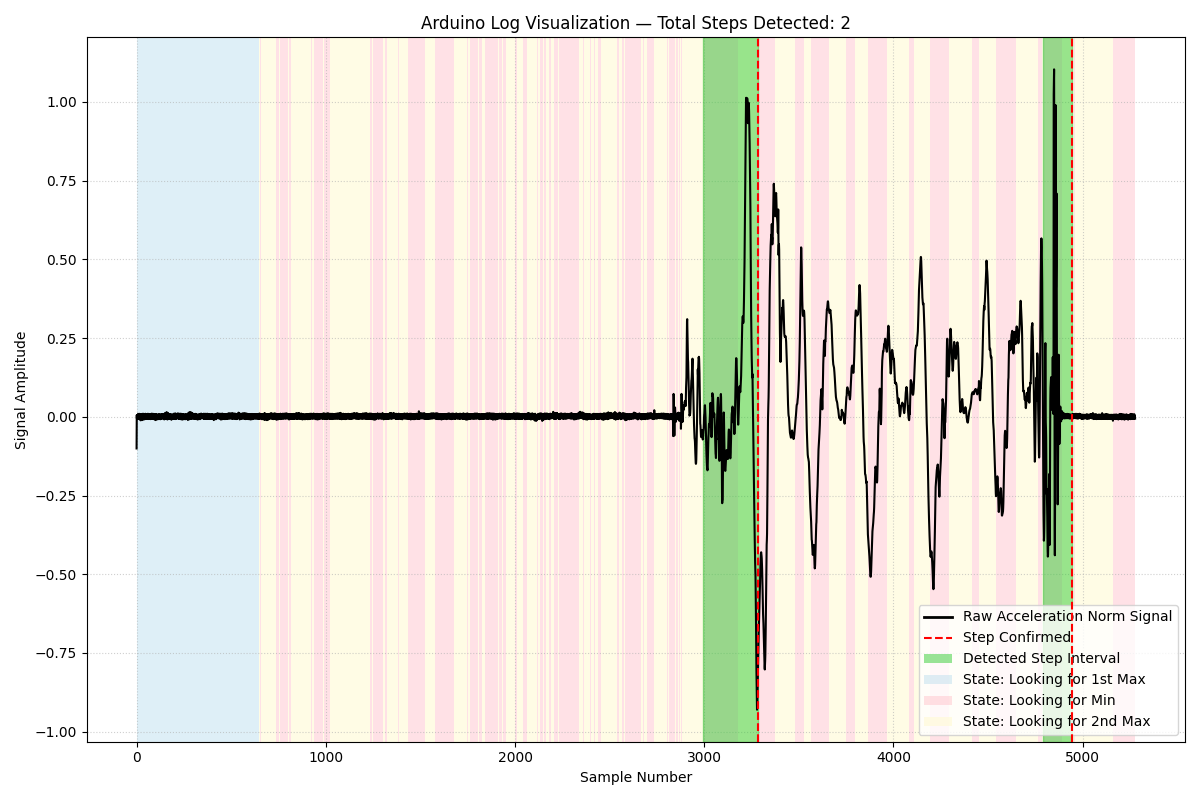

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# --- 2. Plotting ---
fig, ax = plt.subplots(figsize=(12, 8))

# A. Plot the main signal line
ax.plot(df['accel_magnitude'], label='Signal', color='black', zorder=10)

# B. Plot the FSM State Zones from the 'state' column of your DataFrame
state_colors = {
    'LOOKING_FOR_FIRST_MAX': (173/255.0, 216/255.0, 230/250.0, 0.4), # Light Blue
    'LOOKING_FOR_MIN':       (255/255.0, 182/255.0, 193/255.0, 0.4), # Light Pink
    'LOOKING_FOR_SECOND_MAX':(255/255.0, 250/255.0, 205/255.0, 0.5)  # Light Yellow
}

start_index = 0
current_state = df['state'].iloc[0]
for i in range(1, len(df)):
    if df['state'].iloc[i] != current_state:
        ax.axvspan(start_index, i, facecolor=state_colors.get(current_state), zorder=1, edgecolor=None)
        start_index = i
        current_state = df['state'].iloc[i]
ax.axvspan(start_index, len(df) - 1, facecolor=state_colors.get(current_state), zorder=1, edgecolor=None)


# C. Find and plot the "Detected Interval" zones from the DataFrame
step_end_indices = df[df['step_detected'] == 1].index

# Reconstruct the intervals by looking backwards from each detected step
reconstructed_intervals = []
for end_idx in step_end_indices:
    # The state at the end index resets to LOOKING_FOR_MIN.
    # We search backwards from the sample *before* it.
    current_idx = end_idx - 1
    # Step 1: Go back through the "LOOKING_FOR_SECOND_MAX" phase
    while current_idx > 0 and df['state'].iloc[current_idx] == 'LOOKING_FOR_SECOND_MAX':
        current_idx -= 1
    # Step 2: Go back through the "LOOKING_FOR_MIN" phase to find the start peak
    start_idx = current_idx
    while start_idx > 0 and df['state'].iloc[start_idx] == 'LOOKING_FOR_MIN':
        start_idx -= 1
    reconstructed_intervals.append((start_idx, end_idx))

if reconstructed_intervals:
    for i, interval in enumerate(reconstructed_intervals):
        ax.axvspan(interval[0], interval[1], color='limegreen', alpha=0.5, zorder=2)
        ax.axvline(x=interval[1], color='red', linestyle='--', linewidth=1.5, zorder=11)


# D. Create a comprehensive legend and finalize the plot
legend_elements = [
    plt.Line2D([0], [0], color='black', lw=2, label='Raw Acceleration Norm Signal'),
    plt.Line2D([0], [0], color='red', linestyle='--', lw=1.5, label='Step Confirmed'),
    Patch(facecolor='limegreen', alpha=0.5, label='Detected Step Interval'),
    Patch(facecolor=state_colors['LOOKING_FOR_FIRST_MAX'], label='State: Looking for 1st Max'),
    Patch(facecolor=state_colors['LOOKING_FOR_MIN'], label='State: Looking for Min'),
    Patch(facecolor=state_colors['LOOKING_FOR_SECOND_MAX'], label='State: Looking for 2nd Max')
]
ax.legend(handles=legend_elements, loc='best')
ax.set_title(f'Arduino Log Visualization — Total Steps Detected: {len(reconstructed_intervals)}')
ax.set_xlabel('Sample Number')
ax.set_ylabel('Signal Amplitude')
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Filtering

### First part: Exponential moving average

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def exponential_moving_average(signal, alpha):
    """Calculates the Exponential Moving Average of a signal."""
    filtered_signal = [signal[0]]
    for i in range(1, len(signal)):
        new_filtered_value = (alpha * signal[i]) + ((1 - alpha) * filtered_signal[-1])
        filtered_signal.append(new_filtered_value)
    return filtered_signal

# --- Apply the custom filters ---
# Apply Exponential Moving Average with a smoothing factor of 0.1
# A smaller alpha means more smoothing.
alpha = 0.0113
df['ax_lp'] = exponential_moving_average(df['ax'] , alpha=alpha)
df['ay_lp'] = exponential_moving_average(df['ay'] , alpha=alpha)
df['az_lp'] = exponential_moving_average(df['az'] , alpha=alpha)

df['accel_magnitude_lp'] = np.sqrt(df['ax_lp']**2 + df['ay_lp']**2 + df['az_lp']**2) - 1



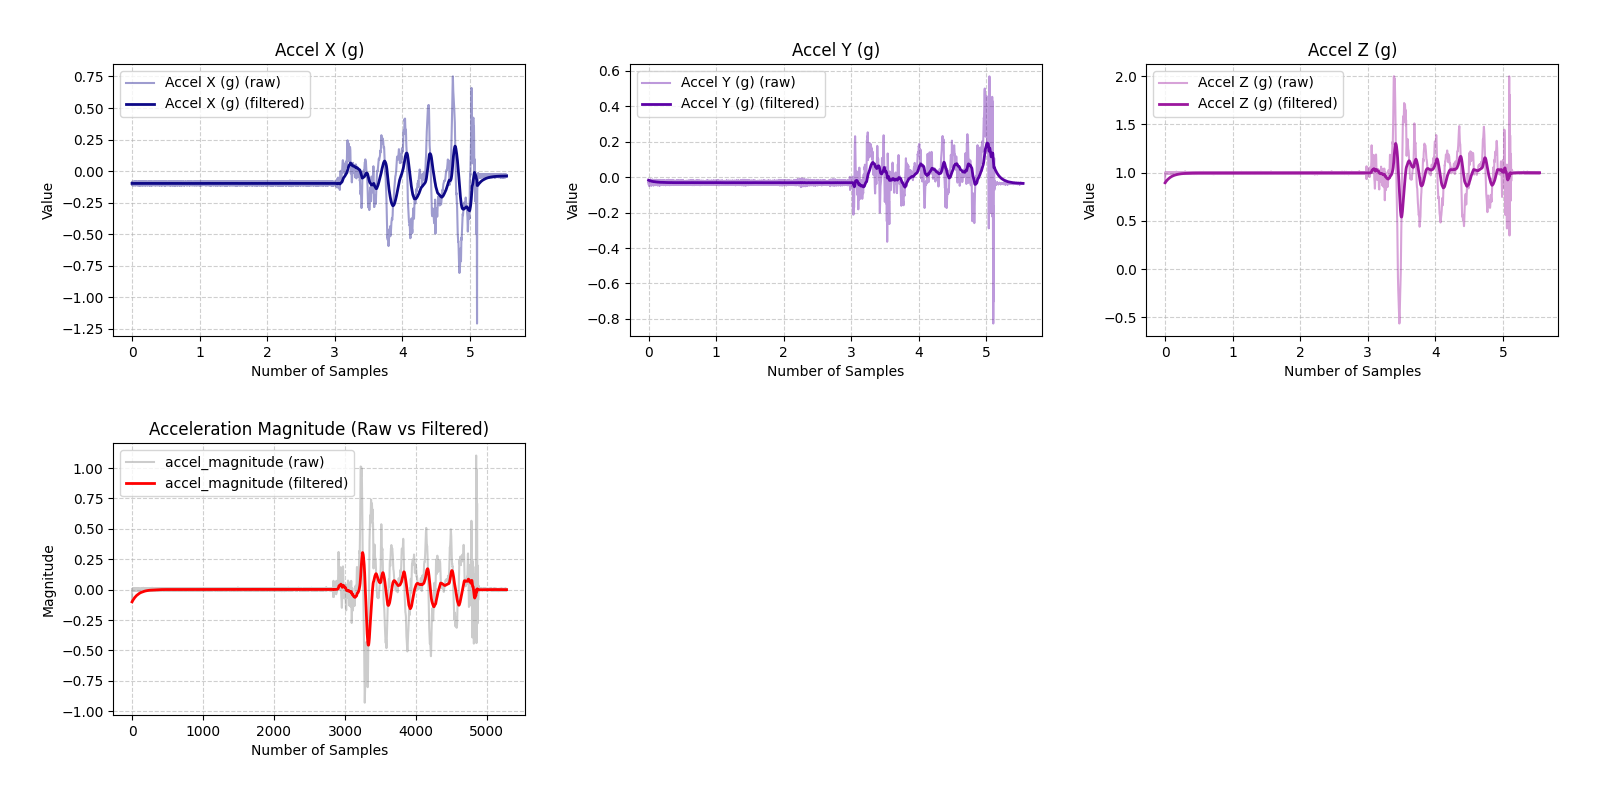

In [4]:
import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots (extra row for the magnitude plot)
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False)

# Flatten axes array
axes = axes.flatten()

# --- Top row: your 3 filtered plots ---
for i in range(3):
    ax = axes[i]  # current subplot axis

    # Get data for this subplot
    col = collumn_names[i]  # make sure variable name is correct (not 'collumn_names')
    raw = df[col]
    filtered = df[col + "_lp"]


    # Plot original and filtered signals
    ax.plot(np.arange(len(df)) / 952, raw, label=f"{titles[i]} (raw)", color=plt.cm.plasma(i / 6), alpha=0.4)
    ax.plot(np.arange(len(df)) / 952, filtered, label=f"{titles[i]} (filtered)", color=plt.cm.plasma(i / 6), linewidth=2)

    # Titles, labels, and grid
    ax.set_title(titles[i], fontsize=12)
    ax.set_ylabel("Value")
    ax.set_xlabel("Number of Samples")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

# --- Bottom plot: accel_magnitude vs accel_magnitude_lp ---
ax_mag = axes[3]  # use the next available subplot (bottom-left position)

ax_mag.plot(df['accel_magnitude'], label='accel_magnitude (raw)', color='gray', alpha=0.4)
ax_mag.plot(df['accel_magnitude_lp'], label='accel_magnitude (filtered)', color='red', linewidth=2)

ax_mag.set_title("Acceleration Magnitude (Raw vs Filtered)", fontsize=12)
ax_mag.set_ylabel("Magnitude")
ax_mag.set_xlabel("Number of Samples")
ax_mag.grid(True, linestyle="--", alpha=0.6)
ax_mag.legend()

# Hide any unused subplots (since we have 4 used out of 6)
for j in range(4, 6):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout(pad=3.0)

# Show figure
plt.show()


### Second part: Simple moving average

aplicar agora um filtro de media para reduzir mais e termos apenas picos UP-DOWN e nao coisas tipo UP-UP(mas menos intenso) e down

o objetivo é tornar o sinal numa espécie de sinusoide para identificar o pico alto e baixo do step e assim ficar com 3 picos bem definidos no intervalo onde começa e acaba o step 

In [5]:
import matplotlib.pyplot as plt

def simple_moving_average(signal, window_size):
    """Calculates the Simple Moving Average of a signal."""
    filtered_signal = []
    for i in range(len(signal)):
        start_index = max(0, i - window_size + 1)
        window = signal[start_index : i + 1]
        window_average = sum(window) / len(window)
        filtered_signal.append(window_average)
    return filtered_signal


#### Efeito do tamanho da window para a média do sinal

Quanto maior o número de samples menos distorcido e mais bem definido fica o sinal, como seria de esperar, no entanto, maior é a perda de informação do sinal

É necessário encontrar um equilíbro, não só neste parâmetro window_size mas também com a combinação window_size e alpha da exponential moving average.

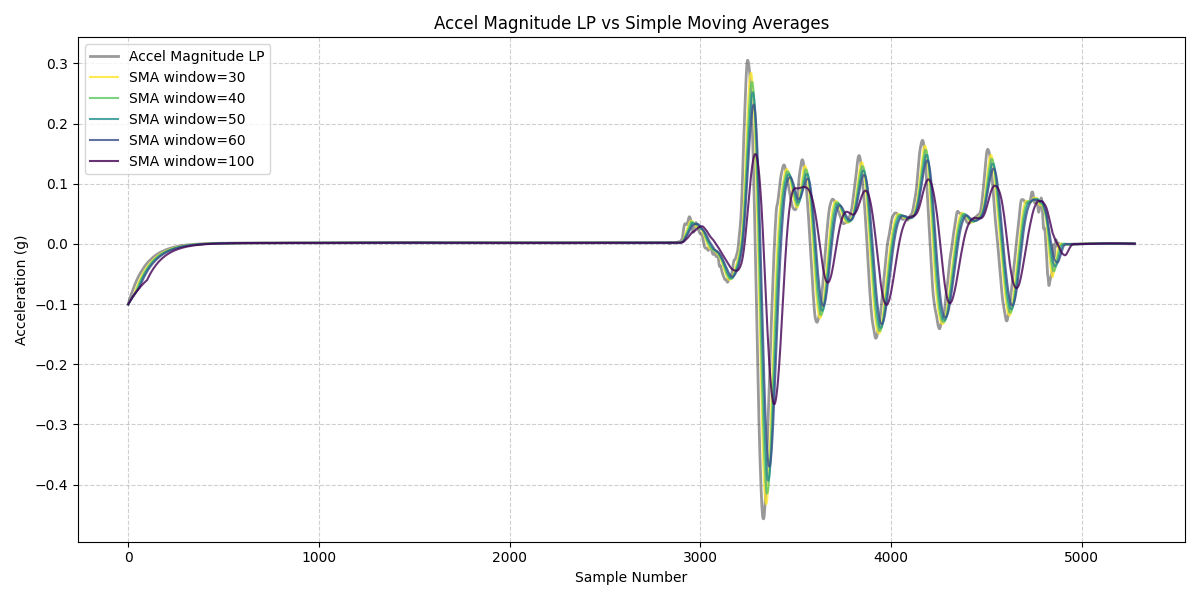

In [6]:
import matplotlib.pyplot as plt


def simple_moving_average(signal, window_size):
    """Calculates the Simple Moving Average of a signal."""
    filtered_signal = []
    for i in range(len(signal)):
        start_index = max(0, i - window_size + 1)
        window = signal[start_index : i + 1]
        window_average = sum(window) / len(window)
        filtered_signal.append(window_average)
    return filtered_signal

# Example window sizes for SMAs
window_sizes = [30, 40, 50, 60, 100]

# Calculate all SMAs of accel_magnitude_lp with different windows
sma_signals = [simple_moving_average(df['accel_magnitude_lp'], w) for w in window_sizes]

plt.figure(figsize=(12, 6))

# Plot the original low-pass filtered accel magnitude
plt.plot(df['accel_magnitude_lp'], label='Accel Magnitude LP', linewidth=2, color='black', alpha=0.4)

# Plot each SMA with different window sizes
colors = plt.cm.viridis_r(np.linspace(0, 1, len(window_sizes)))
for i, (sma, w) in enumerate(zip(sma_signals, window_sizes)):
    plt.plot(sma, label=f'SMA window={w}', alpha=0.8, color=colors[i])

plt.title('Accel Magnitude LP vs Simple Moving Averages')
plt.xlabel('Sample Number')
plt.ylabel('Acceleration (g)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


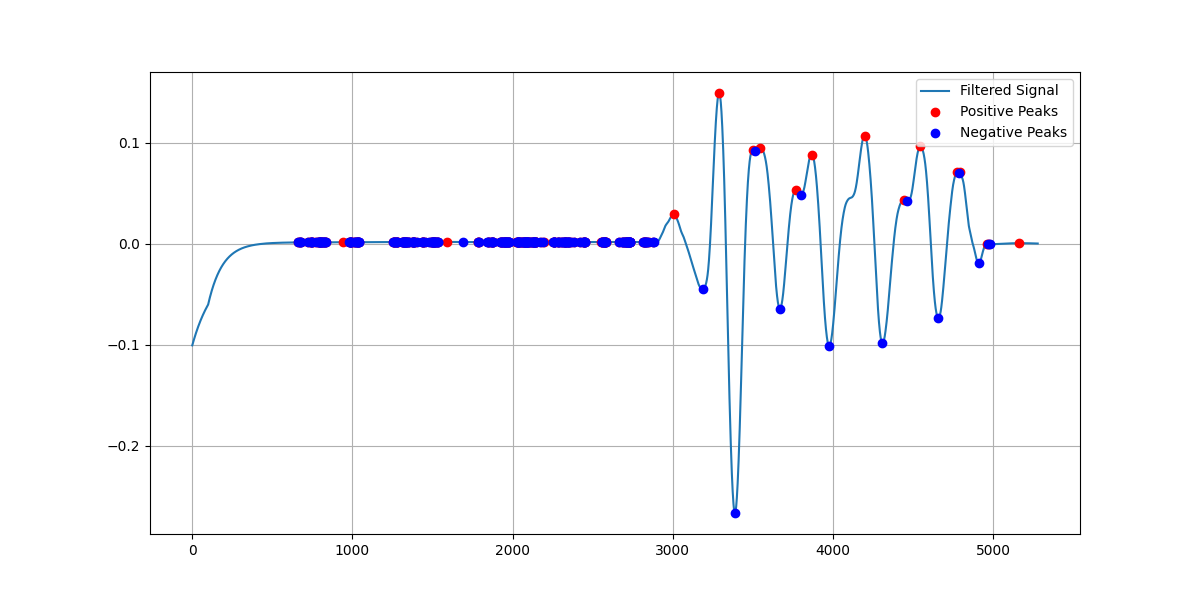

In [7]:
optimal_w = 100
signal = np.array(simple_moving_average(df['accel_magnitude_lp'], optimal_w))

peaks_pos = []
peaks_neg = []

# We'll keep track of the previous two points to check if the middle one is a peak
# Start iterating from index 2, so we have i-2, i-1, i points for checking peaks
for i in range(2, len(signal)):
    prev2 = signal[i-2]
    prev1 = signal[i-1]
    curr = signal[i]

    # Check if prev1 is a positive peak: goes up then down
    if prev1 > prev2 and prev1 > curr:
        peaks_pos.append(i-1)

    # Check if prev1 is a negative peak: goes down then up
    if prev1 < prev2 and prev1 < curr:
        peaks_neg.append(i-1)

plt.figure(figsize=(12, 6))
plt.plot(signal, label='Filtered Signal')
plt.plot(peaks_pos, signal[peaks_pos], 'ro', label='Positive Peaks')
plt.plot(peaks_neg, signal[peaks_neg], 'bo', label='Negative Peaks')
plt.legend()
plt.grid(True)
plt.show()


# Algoritmo com Máquina de Estados 

## Amplitudes relativas

Se as amplitudes relatives entre picos forem respeitadas pelos limites impostos, e se o intervalo do sinal for maior que o requisito min_peak_interval então um pico é detetado

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def find_step_intervals_by_diff(signal, min_peak_interval, 
                                max1_min_diff_bounds, 
                                max2_min_diff_bounds, 
                                max1_max2_diff_bounds):
    """
    Detects steps based on the amplitude differences between peaks in a
    Max -> Min -> Max sequence.

    Args:
        signal (np.array): The input signal data.
        min_peak_interval (int): The minimum number of samples BETWEEN the first
                                 and second positive peaks of a single step.
        max1_min_diff_bounds (tuple): A (lower, upper) bound for the amplitude
                                      difference between Max Peak 1 and the Min Peak.
        max2_min_diff_bounds (tuple): A (lower, upper) bound for the amplitude
                                      difference between Max Peak 2 and the Min Peak.
        max1_max2_diff_bounds (tuple): A (lower, upper) bound for the absolute
                                       amplitude difference between the two Max Peaks.
    Returns:
        list: A list of detected step intervals in the format [sample_max_peak_1, sample_max_peak_2].
    """
    
    step_intervals = []
    state = "LOOKING_FOR_FIRST_MAX"
    candidate_first_max_index = -1
    candidate_min_index = -1

    i = 1
    while i < len(signal) - 1:
        # --- Check for local maximum (positive peak) ---
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1]:
            if state == "LOOKING_FOR_FIRST_MAX":
                # Any positive peak can start a sequence
                state = "LOOKING_FOR_MIN"
                candidate_first_max_index = i
            
            elif state == "LOOKING_FOR_MIN":
                # Found another max before a min. Assume this new one is a better start.
                candidate_first_max_index = i

            elif state == "LOOKING_FOR_SECOND_MAX":
                # --- This is where all validation now happens ---
                max1_val = signal[candidate_first_max_index]
                min_val = signal[candidate_min_index]
                max2_val = signal[i]

                # Calculate the differences
                diff_max1_min = max1_val - min_val
                diff_max2_min = max2_val - min_val
                diff_max1_max2 = abs(max1_val - max2_val) # Absolute difference is more robust
                interval_width = i - candidate_first_max_index

                # --- Check all conditions against their bounds ---
                is_wide_enough = interval_width >= min_peak_interval
                is_max1_min_valid = max1_min_diff_bounds[0] <= diff_max1_min <= max1_min_diff_bounds[1]
                is_max2_min_valid = max2_min_diff_bounds[0] <= diff_max2_min <= max2_min_diff_bounds[1]
                is_max1_max2_valid = max1_max2_diff_bounds[0] <= diff_max1_max2 <= max1_max2_diff_bounds[1]

                if is_wide_enough and is_max1_min_valid and is_max2_min_valid and is_max1_max2_valid:
                    # SUCCESS: The step is valid.
                    step_intervals.append([candidate_first_max_index, i])
                    # Chain the logic: this peak is now the start of the next potential step.
                    state = "LOOKING_FOR_MIN" 
                    candidate_first_max_index = i
                else:
                    # Sequence failed validation. Use this peak as a new potential start.
                    state = "LOOKING_FOR_MIN"
                    candidate_first_max_index = i

        # --- Check for local minimum (negative peak) ---
        if signal[i] < signal[i - 1] and signal[i] < signal[i + 1]:
            if state == "LOOKING_FOR_MIN":
                # Found the valley, now look for the final peak
                state = "LOOKING_FOR_SECOND_MAX"
                candidate_min_index = i
        
        i += 1
        
    return step_intervals


### Hyper tuning parameters

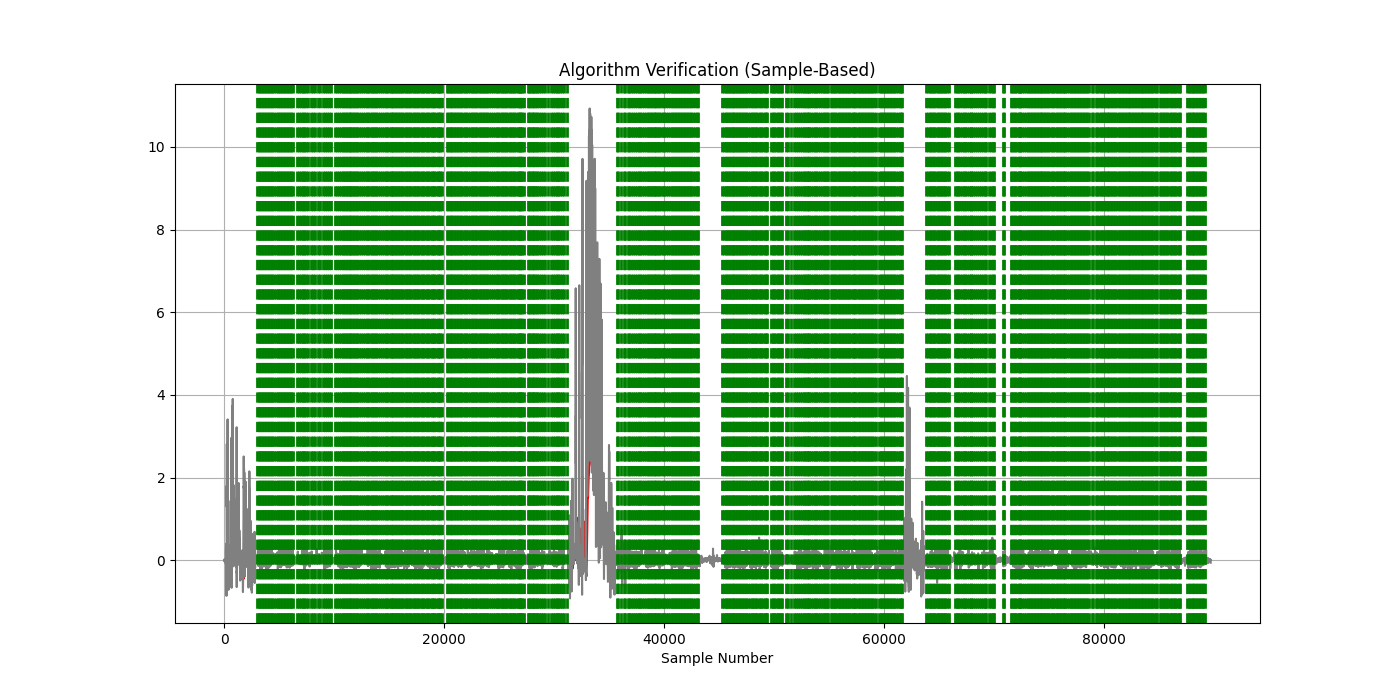

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the recorded data and your manual sample numbers
sensor_data = pd.read_csv("../data/500steps_xico_sensor_data.csv")
manual_steps = pd.read_csv("../data/500steps_xico_manual_step_samples.csv")

# This will give you a list of detected step *indices*, which is exactly what you need.
# For example:
# detected_step_indices = [150, 220, 285, ...] 

sensor_data['ax_lp'] = exponential_moving_average(sensor_data['ax'] , alpha=alpha)
sensor_data['ay_lp'] = exponential_moving_average(sensor_data['ay'] , alpha=alpha)
sensor_data['az_lp'] = exponential_moving_average(sensor_data['az'] , alpha=alpha)

sensor_data['accel_magnitude_lp'] = np.sqrt(sensor_data['ax_lp']**2 + sensor_data['ay_lp']**2 + sensor_data['az_lp']**2) - 1
sensor_data['accel_magnitude'] = np.sqrt(sensor_data['ax']**2 + sensor_data['ay']**2 + sensor_data['az']**2) - 1

signal = np.array(simple_moving_average(sensor_data['accel_magnitude_lp'], optimal_w))

plt.figure(figsize=(14, 7))
plt.plot(signal, label='Processed Accel Signal',color='red')
plt.plot(sensor_data['accel_magnitude'], label='Raw Accel Signal', color='gray')

# Plot the manual steps as vertical lines at the recorded sample numbers
for sample_num in manual_steps['sample_number']:
    plt.axvline(x=sample_num, color='g', linestyle='--', linewidth=2, label='Manual Step (Ground Truth)')


plt.title("Algorithm Verification (Sample-Based)")
plt.xlabel("Sample Number")
plt.grid(True)
plt.show()

Detected 36 steps.
Intervals [Max Peak 1, Max Peak 2]:


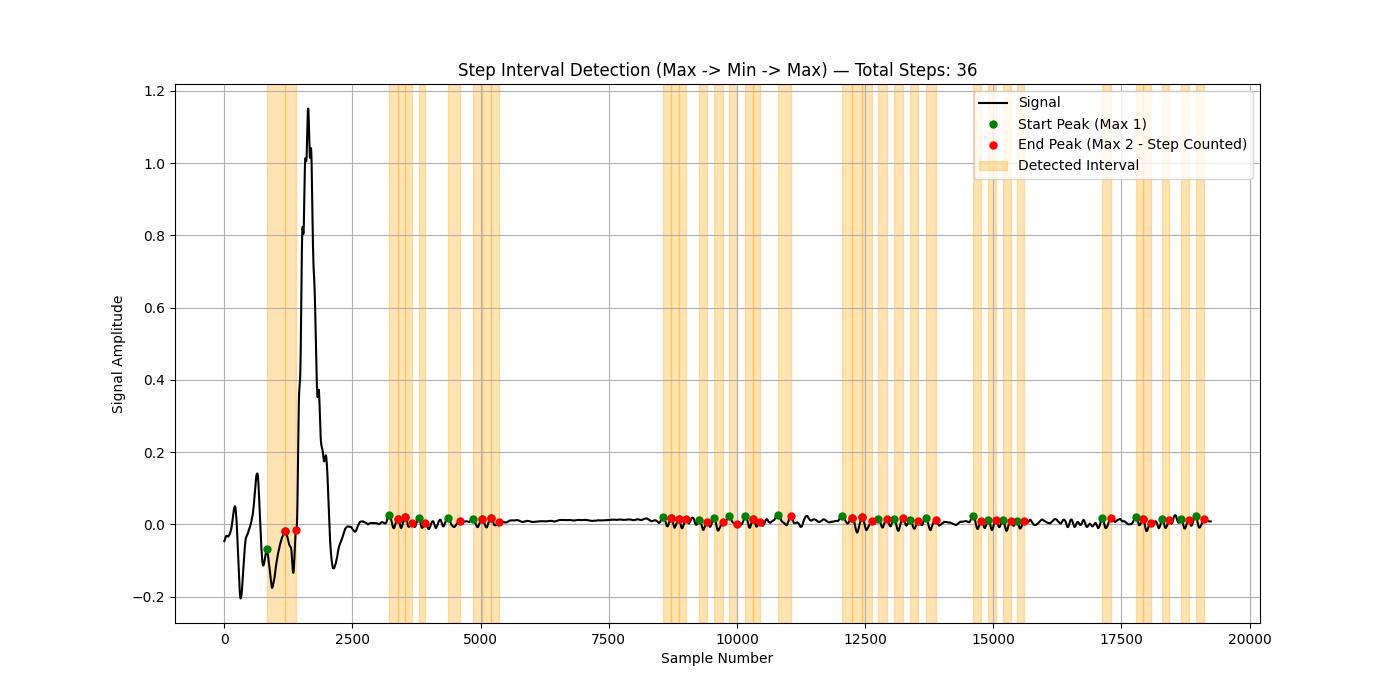

In [ ]:
# 3. Call the new function
detected_intervals = find_step_intervals_by_diff(
    signal=signal,
    min_peak_interval=74,
    max1_min_diff_bounds=(0.0214, 0.1546),
    max2_min_diff_bounds=(0, 0.6653),
    max1_max2_diff_bounds=(0, 0.6557)
)


# 4. Print the output
print(f"Detected {len(detected_intervals)} steps.")
print("Intervals [Max Peak 1, Max Peak 2]:")

# 5. (Optional) Plot the results to verify
plt.figure(figsize=(14, 7))
plt.plot(signal, label='Signal', color='black')

# Unzip the intervals and plot the start and end peaks
if detected_intervals:
    max_peaks_1, max_peaks_2 = zip(*detected_intervals)
    plt.plot(max_peaks_1, signal[list(max_peaks_1)], 'go', markersize=5, label='Start Peak (Max 1)')
    plt.plot(max_peaks_2, signal[list(max_peaks_2)], 'ro', markersize=5, label='End Peak (Max 2 - Step Counted)')
    
    # Shade the area for each detected step interval
    for i, interval in enumerate(detected_intervals):
        label = 'Detected Interval' if i == 0 else ""
        plt.axvspan(interval[0], interval[1], color='orange', alpha=0.3, label=label)


plt.title(f'Step Interval Detection (Max -> Min -> Max) — Total Steps: {len(detected_intervals)}')
plt.xlabel('Sample Number')
plt.ylabel('Signal Amplitude')
plt.grid(True)
plt.legend()
plt.show()

### Testando Accuracy

--- Algorithm Performance ---
Manual Steps Found (True Positives): 37 / 80
Manual Steps Missed (False Negatives): 43
Extra Detections (False Positives): 6


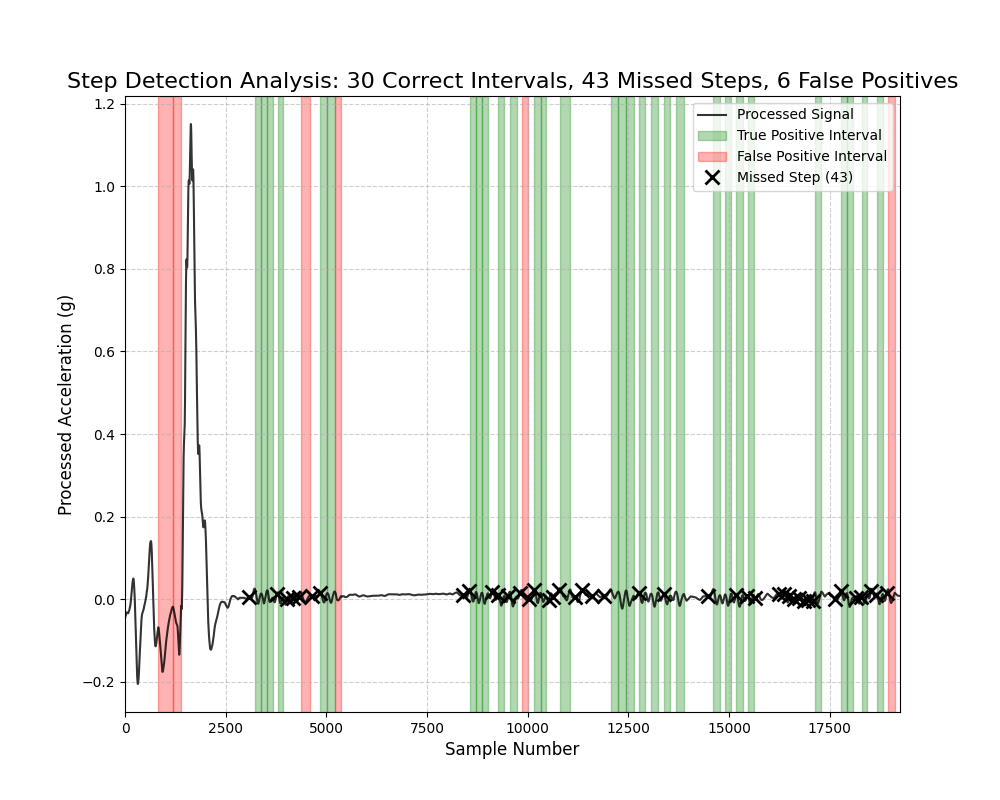

In [ ]:
# =================================================================
# 3. COMPARISON LOGIC
# =================================================================
manual_steps_arr = manual_steps['sample_number'].to_numpy()
is_manual_step_detected = np.zeros(len(manual_steps_arr), dtype=bool)
is_interval_a_true_positive = np.zeros(len(detected_intervals), dtype=bool)

for i, manual_sample in enumerate(manual_steps_arr):
    for j, interval in enumerate(detected_intervals):
        start_peak_index, end_peak_index = interval
        if start_peak_index <= manual_sample <= end_peak_index:
            is_manual_step_detected[i] = True
            is_interval_a_true_positive[j] = True
            # We don't break here, allowing one interval to potentially cover two close manual steps

# Categorize everything
missed_steps = manual_steps_arr[~is_manual_step_detected]
true_positive_intervals = [interval for i, interval in enumerate(detected_intervals) if is_interval_a_true_positive[i]]
false_positive_intervals = [interval for i, interval in enumerate(detected_intervals) if not is_interval_a_true_positive[i]]

print("--- Algorithm Performance ---")
print(f"Manual Steps Found (True Positives): {np.sum(is_manual_step_detected)} / {len(manual_steps_arr)}")
print(f"Manual Steps Missed (False Negatives): {len(missed_steps)}")
print(f"Extra Detections (False Positives): {len(false_positive_intervals)}")

# =================================================================
# 4. PLOTTING
# =================================================================
plt.figure(figsize=(10, 8))

# --- Plot the main signal ---
plt.plot(signal, color='black', label='Processed Signal', zorder=2, alpha=0.8)

# --- Plot the results using shaded areas ---
# True Positives (Green shaded areas)
for i, interval in enumerate(true_positive_intervals):
    label = 'True Positive Interval' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='green', alpha=0.3, label=label, zorder=1)

# False Positives (Red shaded areas)
for i, interval in enumerate(false_positive_intervals):
    label = 'False Positive Interval' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='red', alpha=0.3, label=label, zorder=1)

# Missed Steps (Black 'X' markers)
if len(missed_steps) > 0:
    plt.plot(missed_steps, signal[missed_steps], 'kx', markersize=10, mew=2, label=f'Missed Step ({len(missed_steps)})', zorder=5)

# --- Final Touches ---
title = f"Step Detection Analysis: {len(true_positive_intervals)} Correct Intervals, {len(missed_steps)} Missed Steps, {len(false_positive_intervals)} False Positives"
plt.title(title, fontsize=16)
plt.xlabel("Sample Number", fontsize=12)
plt.ylabel("Processed Acceleration (g)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, len(sensor_data))
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def test_accuracy(detected_intervals, manual_steps_df, verbose=False):
    """
    Calculates and visualizes the performance of a step detection algorithm.

    This function compares the intervals found by an algorithm against a list of
    manually-recorded "ground truth" steps. It calculates performance metrics
    (Precision, Recall, F1-Score) and generates a plot that clearly distinguishes
    between true positives, false positives, and false negatives.

    Args:
        detected_intervals (list): The list of [start, end] intervals returned
                                   by the step detection algorithm.
        manual_steps_df (pd.DataFrame): A DataFrame loaded from your CSV,
                                        containing a 'sample_number' column.
    
    Returns:
        dict: A dictionary containing the calculated performance metrics.
    """
    
    # =================================================================
    # 1. COMPARISON LOGIC
    # =================================================================
    manual_steps_arr = manual_steps_df['sample_number'].to_numpy()
    
    # Boolean flags to track matches
    is_manual_step_detected = np.zeros(len(manual_steps_arr), dtype=bool)
    is_interval_a_true_positive = np.zeros(len(detected_intervals), dtype=bool)

    # Iterate through each manual step to see if it was found
    for i, manual_sample in enumerate(manual_steps_arr):
        for j, interval in enumerate(detected_intervals):
            start_peak_index, end_peak_index = interval
            # Check if the manual step falls within the detected interval
            if start_peak_index <= manual_sample <= end_peak_index:
                is_manual_step_detected[i] = True
                is_interval_a_true_positive[j] = True
                break # A manual step can only be found once

    # --- Calculate performance metrics ---
    true_positives = np.sum(is_manual_step_detected)
    false_negatives = len(manual_steps_arr) - true_positives
    false_positives = len(detected_intervals) - np.sum(is_interval_a_true_positive)
    
    # Precision: Of all the steps we detected, how many were real?
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    # Recall: Of all the real steps that exist, how many did we find?
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    # F1-Score: The harmonic mean of Precision and Recall. A single great score.
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    if verbose:
        print("--- Algorithm Performance Report ---")
        print(f"Manual Steps Found (True Positives):   {true_positives} / {len(manual_steps_arr)}")
        print(f"Manual Steps Missed (False Negatives): {false_negatives}")
        print(f"Extra Detections (False Positives):    {false_positives}")
        print("-" * 36)
        print(f"Precision: {precision:.2%}")
        print(f"Recall:    {recall:.2%}")
        print(f"F1-Score:  {f1_score:.4f}")
        print("-" * 36)
    
    return {
        'true_positives': true_positives,
        'false_negatives': false_negatives,
        'false_positives': false_positives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }


# 4. Call the new function to get the full performance analysis
performance_metrics = test_accuracy(detected_intervals, manual_steps)
print(performance_metrics)

{'true_positives': np.int64(37), 'false_negatives': np.int64(43), 'false_positives': np.int64(6), 'precision': np.float64(0.8604651162790697), 'recall': np.float64(0.4625), 'f1_score': np.float64(0.6016260162601625)}


In [ ]:
import pandas as pd
import numpy as np
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

space  = [
    Integer(10, 500, name='optimal_w'),
    Real(0.01, 0.5, name='alpha'),
    Integer(10, 500, name='min_peak_interval'),
    # Bounds for Max1-Min difference
    Real(0, 0.8, name='max1_min_lower'),
    Real(0, 0.8, name='max1_min_delta'), # USA SE DELTA POI SÉ MAIS FACIL SE DEFINISSE UUM UPPER TINHA Q INICIALIZARA CONSOANTE O LOWER PARA RESPEITAR BOUND
    # Bounds for Max2-Min difference
    Real(0, 0.8, name='max2_min_lower'),
    Real(0, 0.8, name='max2_min_delta'),
    # Bounds for Max1-Max2 difference
    Real(0, 0.8, name='max1_max2_lower'),
    Real(0, 0.8, name='max1_max2_delta'),
]


# --- NEW: Caching dictionary to speed up EMA calculations ---
ema_cache = {}

# --- NEW: Updated Objective Function ---
@use_named_args(space)
def objective(**params):
    """
    NOW, this function recalculates the signal for each run using the
    provided alpha and optimal_w.
    """
    alpha = params['alpha']
    optimal_w = params['optimal_w']

    # --- Caching logic for efficiency ---
    if alpha not in ema_cache:
        # If we haven't seen this alpha before, calculate and store the EMA result
        ax_lp = exponential_moving_average(sensor_data['ax'], alpha)
        ay_lp = exponential_moving_average(sensor_data['ay'], alpha)
        az_lp = exponential_moving_average(sensor_data['az'], alpha)
        accel_mag_lp = np.sqrt(np.square(ax_lp) + np.square(ay_lp) + np.square(az_lp)) - 1.0
        ema_cache[alpha] = accel_mag_lp
    
    # Retrieve the (possibly cached) EMA result
    accel_magnitude_lp = ema_cache[alpha]

    # --- Generate the final signal for this run ---
    signal = simple_moving_average(accel_magnitude_lp, optimal_w)
    
    # --- Reconstruct the bounds for the detection algorithm ---
    max1_min_b = (params['max1_min_lower'], params['max1_min_lower'] + params['max1_min_delta'])
    max2_min_b = (params['max2_min_lower'], params['max2_min_lower'] + params['max2_min_delta'])
    max1_max2_b = (params['max1_max2_lower'], params['max1_max2_lower'] + params['max1_max2_delta'])

    # Run the core algorithm on the newly generated signal
    detected_intervals = find_step_intervals_by_diff(
        signal=signal,
        min_peak_interval=params['min_peak_interval'],
        max1_min_diff_bounds=max1_min_b,
        max2_min_diff_bounds=max2_min_b,
        max1_max2_diff_bounds=max1_max2_b
    )
    
    f1 = test_accuracy(detected_intervals, manual_steps)['f1_score']
    return 1.0 - f1


# 2. Run the Bayesian Optimization
# n_calls is your "budget" for how many combinations to test.
print("Starting Bayesian Optimization to find the best parameters...")
start_time = time.time()


initial_params = [
    # [np.int64(100), 0.06748036004974223, np.int64(100), 0.004141875561478496, 0.4090256644585729, 0.018514232057777035, 0.378782748614783, 0.0, 0.6275043927369609]
    # [np.int64(130), 0.03, np.int64(81), 0.0, 0.607802698857589, 0.0, 0.6888716620101909, 0.0, 0.8],
    # [np.int64(82), 0.011286980668246436, np.int64(74), 0.02143678646509661, 0.15463255015788627, 0.0, 0.6652631489832426, 0.0, 0.655675569896947]
]

result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=300,       # Total number of combinations to test
    random_state=42,
    # x0=initial_params,
    verbose=True,
    n_jobs=-1
)

end_time = time.time()
print(f"\nOptimization complete in {end_time - start_time:.2f} seconds.")

# 3. Present the best results
best_f1_score = 1.0 - result.fun
best_parameters = result.x

# Map the parameter list back to names for readability
best_params_dict = {param.name: value for param, value in zip(space, best_parameters)}

print("\n" + "="*50)
print("           BEST PARAMETERS FOUND")
print("="*50)
print(f"\nBest F1-Score: {best_f1_score:.4f}")
print("Optimal Parameters:")
for name, value in best_params_dict.items():
    if isinstance(value, float):
        print(f"  - {name}: {value:.4f}")
    else:
        print(f"  - {name}: {value}")


print(best_params_dict.values())

Starting Bayesian Optimization to find the best parameters...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8151
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6376
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1571
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 4 started. Evaluating function at random point.


KeyboardInterrupt: 

### Plot best result

In [ ]:
alpha = best_params_dict['alpha']
optimal_w = best_params_dict['optimal_w']

accel_magnitude_lp = ema_cache[alpha]
signal_best = simple_moving_average(accel_magnitude_lp, optimal_w)

max1_min_b = (best_params_dict['max1_min_lower'], best_params_dict['max1_min_lower'] + best_params_dict['max1_min_delta'])
max2_min_b = (best_params_dict['max2_min_lower'], best_params_dict['max2_min_lower'] + best_params_dict['max2_min_delta'])
max1_max2_b = (best_params_dict['max1_max2_lower'], best_params_dict['max1_max2_lower'] + best_params_dict['max1_max2_delta'])

detected_intervals = find_step_intervals_by_diff(
    signal=signal_best,
    min_peak_interval=best_params_dict['min_peak_interval'],
    max1_min_diff_bounds=max1_min_b,
    max2_min_diff_bounds=max2_min_b,
    max1_max2_diff_bounds=max1_max2_b
)

test_accuracy(detected_intervals, manual_steps, verbose=True) # 78/86/82.55

--- Algorithm Performance Report ---
Manual Steps Found (True Positives):   74 / 80
Manual Steps Missed (False Negatives): 6
Extra Detections (False Positives):    9
------------------------------------
Precision: 89.16%
Recall:    92.50%
F1-Score:  0.9080
------------------------------------


{'true_positives': np.int64(74),
 'false_negatives': np.int64(6),
 'false_positives': np.int64(9),
 'precision': np.float64(0.891566265060241),
 'recall': np.float64(0.925),
 'f1_score': np.float64(0.9079754601226994)}


         VISUALIZING THE BEST PARAMETER SET

Running final detection with the best parameters...

--- Final Performance Report ---
F1-Score: 0.9080 (Precision: 89.16%, Recall: 92.50%)
  - Correctly Detected: 74
  - Missed Steps:       6
  - False Detections:   9


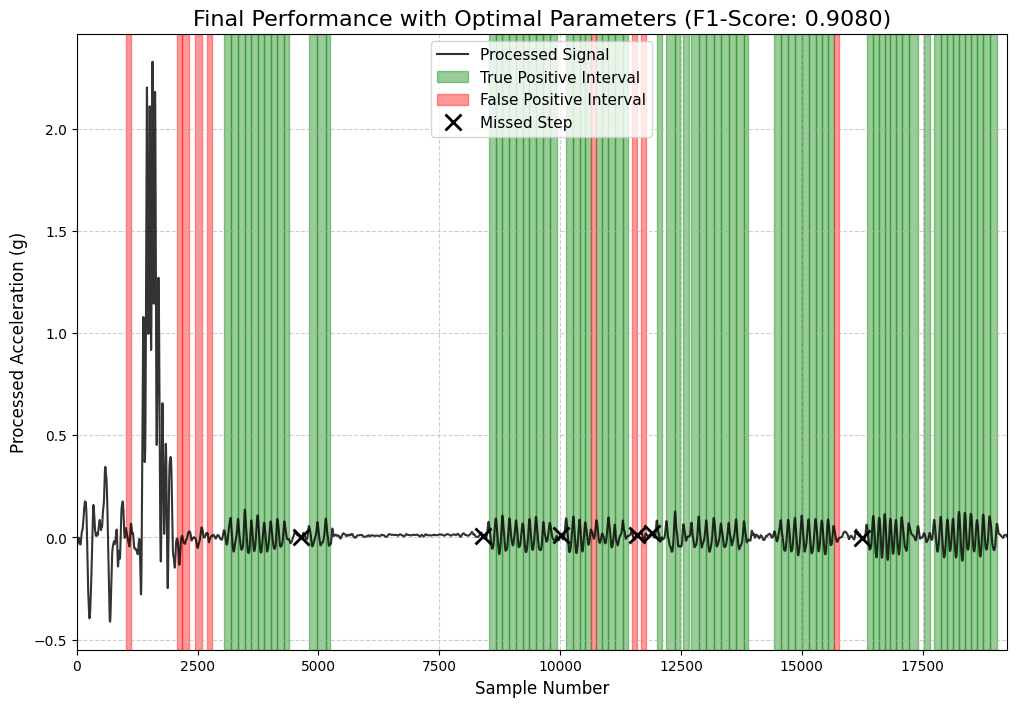

In [ ]:
def plot_best_result(signal, manual_steps_df, best_params):
    """
    Takes the best parameters, runs the algorithm, and generates a
    detailed performance plot.

    Args:
        signal (np.array): The processed signal that was analyzed.
        manual_steps_df (pd.DataFrame): DataFrame with 'sample_number' column.
        best_params (dict): Dictionary of the best parameters found by the optimizer.
    """
    print("\n" + "="*55)
    print("         VISUALIZING THE BEST PARAMETER SET")
    print("="*55)

    signal = np.asarray(signal)

    # --- 1. Reconstruct the bounds from the best parameters ---
    m1m_lower = best_params['max1_min_lower']
    m1m_upper = m1m_lower + best_params['max1_min_delta']
    max1_min_b = (m1m_lower, m1m_upper)

    m2m_lower = best_params['max2_min_lower']
    m2m_upper = m2m_lower + best_params['max2_min_delta']
    max2_min_b = (m2m_lower, m2m_upper)
    
    m1m2_lower = best_params['max1_max2_lower']
    m1m2_upper = m1m2_lower + best_params['max1_max2_delta']
    max1_max2_b = (m1m2_lower, m1m2_upper)

    # --- 2. Run the detection algorithm with the optimal parameters ---
    print("\nRunning final detection with the best parameters...")
    detected_intervals = find_step_intervals_by_diff(
        signal=signal,
        min_peak_interval=best_params['min_peak_interval'],
        max1_min_diff_bounds=max1_min_b,
        max2_min_diff_bounds=max2_min_b,
        max1_max2_diff_bounds=max1_max2_b
    )

    # --- 3. Perform the comparison logic ---
    manual_steps_arr = manual_steps_df['sample_number'].to_numpy()
    is_manual_step_detected = np.zeros(len(manual_steps_arr), dtype=bool)
    is_interval_a_true_positive = np.zeros(len(detected_intervals), dtype=bool)

    for i, manual_sample in enumerate(manual_steps_arr):
        for j, interval in enumerate(detected_intervals):
            if interval[0] <= manual_sample <= interval[1]:
                is_manual_step_detected[i] = True
                is_interval_a_true_positive[j] = True
                break
    
    true_positives = np.sum(is_manual_step_detected)
    false_negatives = len(manual_steps_arr) - true_positives
    false_positives = len(detected_intervals) - np.sum(is_interval_a_true_positive)
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\n--- Final Performance Report ---")
    print(f"F1-Score: {f1_score:.4f} (Precision: {precision:.2%}, Recall: {recall:.2%})")
    print(f"  - Correctly Detected: {true_positives}")
    print(f"  - Missed Steps:       {false_negatives}")
    print(f"  - False Detections:   {false_positives}")

    # --- 4. Generate the detailed plot ---
    true_positive_intervals = [interval for i, interval in enumerate(detected_intervals) if is_interval_a_true_positive[i]]
    false_positive_intervals = [interval for i, interval in enumerate(detected_intervals) if not is_interval_a_true_positive[i]]
    missed_steps = manual_steps_arr[~is_manual_step_detected]

    plt.figure(figsize=(12, 8))
    plt.plot(signal, color='black', label='Processed Signal', zorder=2, alpha=0.8)

    # Plot True Positives (Green shaded areas)
    for i, interval in enumerate(true_positive_intervals):
        label = 'True Positive Interval' if i == 0 else ""
        plt.axvspan(interval[0], interval[1], color='green', alpha=0.4, label=label, zorder=1)

    # Plot False Positives (Red shaded areas)
    for i, interval in enumerate(false_positive_intervals):
        label = 'False Positive Interval' if i == 0 else ""
        plt.axvspan(interval[0], interval[1], color='red', alpha=0.4, label=label, zorder=1)

    # Plot Missed Steps (Black 'X' markers)
    valid_missed = missed_steps[missed_steps < len(signal)]

    if len(valid_missed) > 0:
        plt.plot(valid_missed, signal[valid_missed], 'kx', markersize=12, mew=2, label='Missed Step', zorder=5)

    title = f"Final Performance with Optimal Parameters (F1-Score: {f1_score:.4f})"
    plt.title(title, fontsize=16)
    plt.xlabel("Sample Number", fontsize=12)
    plt.ylabel("Processed Acceleration (g)", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, len(signal))
    plt.show()


plot_best_result(signal_best, manual_steps, best_params_dict)


## Neural Networks :)

Calcular todos os intervalos que podem ser um possível step, isto é sequências de Picos Max->min->Max, obter features, e alimentar neural network com essas features

### Obter Features

In [22]:
import numpy as np
import pandas as pd

def extract_and_label_features_by_containment(signal, manual_step_samples):
    """
    Scans for all "Max -> Min -> Max" sequences, extracts features, and labels
    them as a true step if a manual step sample is contained within the interval.

    Args:
        signal (np.array): The input signal data.
        manual_step_samples (list or np.array): A list of sample numbers where
                                                true steps are known to occur.

    Returns:
        tuple: A tuple containing:
            - features (list of lists): Feature vectors for each potential step.
            - labels (list): Labels (1 for a true step, 0 for a non-step).
            - detected_intervals (list): The [start, end] of each potential interval found.
    """
    features = []
    labels = []
    detected_intervals = []
    
    state = "LOOKING_FOR_FIRST_MAX"
    candidate_first_max_index = -1
    candidate_min_index = -1

    # Using the list directly is fine for this logic
    
    i = 1
    while i < len(signal) - 1:
        # --- Check for local maximum (positive peak) ---
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1]:
            if state == "LOOKING_FOR_FIRST_MAX":
                state = "LOOKING_FOR_MIN"
                candidate_first_max_index = i
            
            elif state == "LOOKING_FOR_MIN":
                candidate_first_max_index = i

            elif state == "LOOKING_FOR_SECOND_MAX":
                max1_idx = candidate_first_max_index
                min_idx = candidate_min_index
                max2_idx = i

                # --- 1. Feature Extraction (same as before) ---
                feature_vector = [
                    signal[max1_idx], signal[min_idx], signal[max2_idx],
                    signal[max1_idx] - signal[min_idx],
                    signal[max2_idx] - signal[min_idx],
                    abs(signal[max1_idx] - signal[max2_idx]),
                    min_idx - max1_idx,
                    max2_idx - min_idx,
                    max2_idx - max1_idx
                ]
                features.append(feature_vector)
                current_interval = [max1_idx, max2_idx]
                detected_intervals.append(current_interval)

                # --- 2. NEW Labeling Logic: Check for containment ---
                is_true_step = any(max1_idx <= manual_sample <= max2_idx for manual_sample in manual_step_samples)
                
                if is_true_step:
                    labels.append(1)
                else:
                    labels.append(0)

                state = "LOOKING_FOR_MIN"
                candidate_first_max_index = i

        # --- Check for local minimum (negative peak) ---
        if signal[i] < signal[i - 1] and signal[i] < signal[i + 1]:
            if state == "LOOKING_FOR_MIN":
                state = "LOOKING_FOR_SECOND_MAX"
                candidate_min_index = i
        
        i += 1
        
    return np.array(features), np.array(labels), np.array(detected_intervals)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

manual_steps_list = manual_steps['sample_number'].to_numpy()

# --- 2. Extract Features and Labels ---
X, y, intervals = extract_and_label_features_by_containment(
    signal=signal,
    manual_step_samples=manual_steps_list
)

X = np.array(X)
y = np.array(y)
intervals = np.array(intervals) # Convert to numpy array for splitting

print(f"\nExtracted {len(X)} total potential intervals.")
print(f"Labeled {sum(y)} as TRUE steps and {len(y) - sum(y)} as NON-steps.")


# --- 3. Split ALL Data: Features, Labels, AND Intervals ---
print("\n--- Training Neural Network ---")

# CRITICAL STEP: Split the 'intervals' array along with X and y
X_train, X_test, y_train, y_test, intervals_train, intervals_test = train_test_split(
    X, y, intervals, test_size=0.20, random_state=42, stratify=y
)

# --- 4. Scale Data and Train Model ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)
print("Model training complete.")


# --- 5. Evaluate Model and Get Predictions ---
print("\n--- Evaluating Model on Test Data ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Step', 'Step']))


# =================================================================
# 6. NEW: CATEGORIZE PREDICTIONS FOR PLOTTING
# =================================================================
true_positive_intervals = []
false_positive_intervals = []
false_negative_intervals = []

for i in range(len(y_test)):
    interval = intervals_test[i]
    true_label = y_test[i]
    predicted_label = y_pred[i]
    
    if predicted_label == 1 and true_label == 1:
        true_positive_intervals.append(interval)
    elif predicted_label == 1 and true_label == 0:
        false_positive_intervals.append(interval)
    elif predicted_label == 0 and true_label == 1:
        false_negative_intervals.append(interval)

print("\n--- Prediction Analysis on Test Set ---")
print(f"Correctly Identified Steps (True Positives): {len(true_positive_intervals)}")
print(f"Missed Steps (False Negatives): {len(false_negative_intervals)}")
print(f"Incorrect Detections (False Positives): {len(false_positive_intervals)}")




Extracted 612 total potential intervals.
Labeled 457 as TRUE steps and 155 as NON-steps.

--- Training Neural Network ---


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model training complete.

--- Evaluating Model on Test Data ---
Test Accuracy: 0.8618
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f4b35aaf880> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:
              precision    recall  f1-score   support

    Non-Step       0.85      0.55    

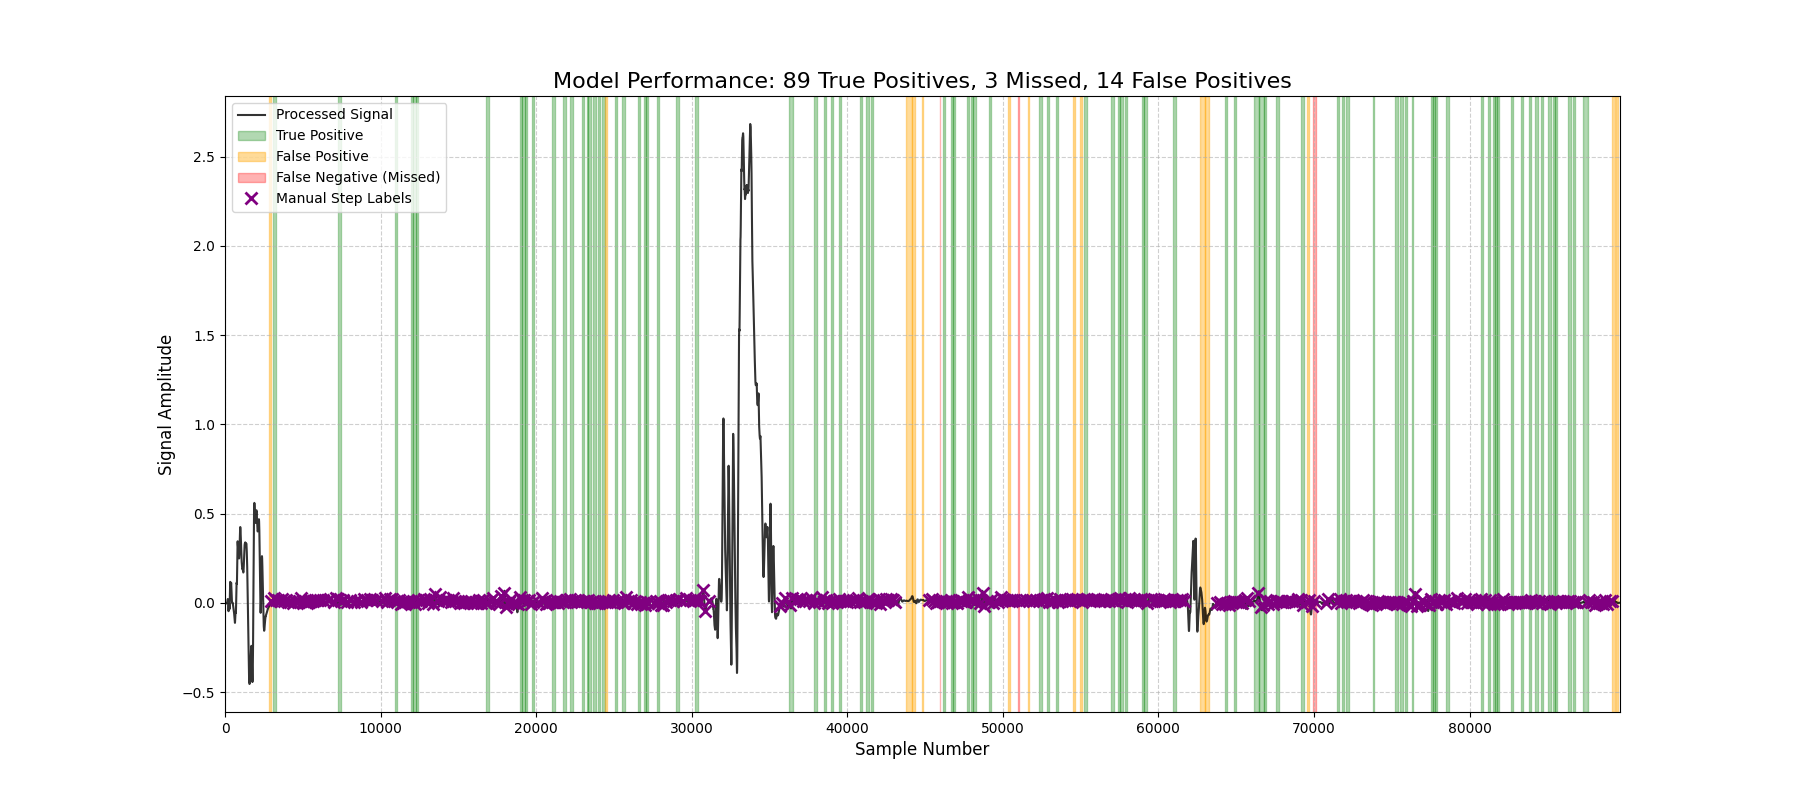

In [24]:

# =================================================================
# 7. NEW: DETAILED VISUALIZATION OF MODEL PERFORMANCE
# =================================================================
plt.figure(figsize=(18, 8))

# --- Plot the main signal ---
plt.plot(signal, color='black', label='Processed Signal', zorder=2, alpha=0.8)

# --- Plot the results using shaded areas ---
# True Positives (Green)
for i, interval in enumerate(true_positive_intervals):
    label = 'True Positive' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='green', alpha=0.3, label=label, zorder=1)

# False Positives (Orange) - The model said "step" but it wasn't
for i, interval in enumerate(false_positive_intervals):
    label = 'False Positive' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='orange', alpha=0.4, label=label, zorder=1)
    
# False Negatives (Red) - A real step that the model missed
for i, interval in enumerate(false_negative_intervals):
    label = 'False Negative (Missed)' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='red', alpha=0.3, label=label, zorder=1)

# --- Plot ground truth for reference ---
plt.plot(manual_steps_list, signal[manual_steps_list], 'x', color='purple', markersize=8, mew=2, label='Manual Step Labels', zorder=5)


# --- Final Touches ---
title = f"Model Performance: {len(true_positive_intervals)} True Positives, {len(false_negative_intervals)} Missed, {len(false_positive_intervals)} False Positives"
plt.title(title, fontsize=16)
plt.xlabel("Sample Number", fontsize=12)
plt.ylabel("Signal Amplitude", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional: Zoom into the area covered by the test set to see details
if len(intervals_test) > 0:
    plot_start = intervals_test[:, 0].min() - 200
    plot_end = intervals_test[:, 1].max() + 200
    plt.xlim(max(0, plot_start), min(len(signal), plot_end))

plt.show()

### Hyper parameter tuning

Usamos Bayesian Optimization mais uma vez, é time expensive treinar várias vezes redes neuronais, neste caso cada treino leva ~7s

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import time

# --- Import the Bayesian Optimization tools ---
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# --- Define the Search Space for the Optimizer ---
# These are the hyperparameters we want to tune.
search_space = [
    Integer(10, 400, name='optimal_w'),
    Real(0.001, 0.5, name='alpha')
]

# --- Caching to speed things up ---
# The EMA calculation only depends on alpha. We can cache its result.
ema_cache = {}

# =================================================================
# 3. DEFINE THE OBJECTIVE FUNCTION
# =================================================================

@use_named_args(search_space)
def objective(optimal_w, alpha):
    """
    This function takes hyperparameters, runs the entire ML pipeline,
    and returns a score for the optimizer to minimize.
    """
    print(f"Trying: w = {optimal_w}, alpha = {alpha:.4f}")

    # --- Step A: Generate the Signal using the given parameters ---
    alpha_key = f"{alpha:.6f}" # Use a string key for float
    if alpha_key not in ema_cache:
        ax_lp = exponential_moving_average(sensor_data['ax'], alpha=alpha)
        ay_lp = exponential_moving_average(sensor_data['ay'], alpha=alpha)
        az_lp = exponential_moving_average(sensor_data['az'], alpha=alpha)
        accel_mag_lp = np.sqrt(np.array(ax_lp)**2 + np.array(ay_lp)**2 + np.array(az_lp)**2) - 1.0
        ema_cache[alpha_key] = accel_mag_lp
    
    accel_magnitude_lp = ema_cache[alpha_key]
    signal = simple_moving_average(accel_magnitude_lp, window_size=optimal_w)

    # --- Step B: Feature Extraction ---
    X, y, _ = extract_and_label_features_by_containment(signal, manual_steps_list)
    
    # --- Step C: Handle Edge Cases ---
    # If parameters create a signal with too few intervals or only one class,
    # it's a bad combination. Return the worst possible score.
    if len(X) < 20 or len(np.unique(y)) < 2:
        print("--> Bad parameters (not enough data). Score: 0.0")
        return 1.0 # Return 1.0 because we want to MINIMIZE (1.0 - f1_score)

    # --- Step D: Train and Evaluate the Neural Network ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)), Dropout(0.4),
        Dense(16, activation='relu'), Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
              callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
              verbose=0)
    
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    
    # --- Step E: Calculate and Return the Score ---
    # We use F1-score as it's better for classification than pure accuracy.
    score = f1_score(y_test, y_pred, zero_division=0)
    print(f"--> F1-Score: {score:.4f}")
    
    # gp_minimize tries to find the MINIMUM value, so we return 1 minus our score.
    return 1.0 - score



print("\nStarting Bayesian Optimization to find best 'alpha' and 'optimal_w'...")
start_time = time.time()

# n_calls is your "budget" for how many combinations to test.
# 50-100 is a good starting point.
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=50,
    random_state=42,
    verbose=True
)

end_time = time.time()
print(f"\nOptimization complete in {end_time - start_time:.2f} seconds.")

# =================================================================
# 5. PRESENT THE BEST RESULTS
# =================================================================

best_f1_score = 1.0 - result.fun
best_parameters = result.x

print("\n" + "="*50)
print("           BEST PARAMETERS FOUND")
print("="*50)
print(f"\nBest F1-Score on Validation: {best_f1_score:.4f}")
print("Optimal Parameters:")
print(f"  - optimal_w: {best_parameters[0]}")
print(f"  - alpha:     {best_parameters[1]:.4f}")


Starting Bayesian Optimization to find best 'alpha' and 'optimal_w'...
Iteration No: 1 started. Evaluating function at random point.
Trying: w = 321, alpha = 0.0925


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F1-Score: 0.7511
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.1811
Function value obtained: 0.2489
Current minimum: 0.2489
Iteration No: 2 started. Evaluating function at random point.
Trying: w = 314, alpha = 0.2988


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.6415
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.8892
Function value obtained: 0.3585
Current minimum: 0.2489
Iteration No: 3 started. Evaluating function at random point.
Trying: w = 184, alpha = 0.0509


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
--> F1-Score: 0.8240
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.6142
Function value obtained: 0.1760
Current minimum: 0.1760
Iteration No: 4 started. Evaluating function at random point.
Trying: w = 189, alpha = 0.1675


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F1-Score: 0.7745
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.0475
Function value obtained: 0.2255
Current minimum: 0.1760
Iteration No: 5 started. Evaluating function at random point.
Trying: w = 66, alpha = 0.3258


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.7213
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.2727
Function value obtained: 0.2787
Current minimum: 0.1760
Iteration No: 6 started. Evaluating function at random point.
Trying: w = 32, alpha = 0.3613


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.8032
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 9.5053
Function value obtained: 0.1968
Current minimum: 0.1760
Iteration No: 7 started. Evaluating function at random point.
Trying: w = 376, alpha = 0.0014


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
--> F1-Score: 0.9057
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 11.6436
Function value obtained: 0.0943
Current minimum: 0.0943
Iteration No: 8 started. Evaluating function at random point.
Trying: w = 397, alpha = 0.3091


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.4396
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 13.2727
Function value obtained: 0.5604
Current minimum: 0.0943
Iteration No: 9 started. Evaluating function at random point.
Trying: w = 249, alpha = 0.0045


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
--> F1-Score: 0.8926
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 6.6585
Function value obtained: 0.1074
Current minimum: 0.0943
Iteration No: 10 started. Evaluating function at random point.
Trying: w = 19, alpha = 0.2629


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F1-Score: 0.5263
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.9245
Function value obtained: 0.4737
Current minimum: 0.0943
Iteration No: 11 started. Searching for the next optimal point.
Trying: w = 337, alpha = 0.0172


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F1-Score: 0.8313
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 6.7894
Function value obtained: 0.1687
Current minimum: 0.0943
Iteration No: 12 started. Searching for the next optimal point.
Trying: w = 378, alpha = 0.0351


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F1-Score: 0.8235
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 11.1156
Function value obtained: 0.1765
Current minimum: 0.0943
Iteration No: 13 started. Searching for the next optimal point.
Trying: w = 78, alpha = 0.5000


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F1-Score: 0.7124
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 4.7074
Function value obtained: 0.2876
Current minimum: 0.0943
Iteration No: 14 started. Searching for the next optimal point.
Trying: w = 10, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F1-Score: 0.7230
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 10.4637
Function value obtained: 0.2770
Current minimum: 0.0943
Iteration No: 15 started. Searching for the next optimal point.
Trying: w = 400, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
--> F1-Score: 0.8390
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 6.1832
Function value obtained: 0.1610
Current minimum: 0.0943
Iteration No: 16 started. Searching for the next optimal point.
Trying: w = 186, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.8720
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 6.4382
Function value obtained: 0.1280
Current minimum: 0.0943
Iteration No: 17 started. Searching for the next optimal point.
Trying: w = 336, alpha = 0.5000


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.6812
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.6290
Function value obtained: 0.3188
Current minimum: 0.0943
Iteration No: 18 started. Searching for the next optimal point.
Trying: w = 147, alpha = 0.3978


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F1-Score: 0.2593
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 7.0538
Function value obtained: 0.7407
Current minimum: 0.0943
Iteration No: 19 started. Searching for the next optimal point.
Trying: w = 10, alpha = 0.0346


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.6667
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 6.1011
Function value obtained: 0.3333
Current minimum: 0.0943
Iteration No: 20 started. Searching for the next optimal point.
Trying: w = 10, alpha = 0.5000


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
--> F1-Score: 0.5588
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.1023
Function value obtained: 0.4412
Current minimum: 0.0943
Iteration No: 21 started. Searching for the next optimal point.
Trying: w = 223, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
--> F1-Score: 0.8899
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 5.0849
Function value obtained: 0.1101
Current minimum: 0.0943
Iteration No: 22 started. Searching for the next optimal point.
Trying: w = 365, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
--> F1-Score: 0.8889
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 9.1351
Function value obtained: 0.1111
Current minimum: 0.0943
Iteration No: 23 started. Searching for the next optimal point.
Trying: w = 243, alpha = 0.0435


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F1-Score: 0.8496
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.2667
Function value obtained: 0.1504
Current minimum: 0.0943
Iteration No: 24 started. Searching for the next optimal point.
Trying: w = 115, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
--> F1-Score: 0.8940
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.4296
Function value obtained: 0.1060
Current minimum: 0.0943
Iteration No: 25 started. Searching for the next optimal point.
Trying: w = 143, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.8023
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.7316
Function value obtained: 0.1977
Current minimum: 0.0943
Iteration No: 26 started. Searching for the next optimal point.
Trying: w = 98, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F1-Score: 0.9046
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 5.2079
Function value obtained: 0.0954
Current minimum: 0.0943
Iteration No: 27 started. Searching for the next optimal point.
Trying: w = 276, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.8469
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 11.0912
Function value obtained: 0.1531
Current minimum: 0.0943
Iteration No: 28 started. Searching for the next optimal point.
Trying: w = 101, alpha = 0.0246


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F1-Score: 0.9174
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 6.4742
Function value obtained: 0.0826
Current minimum: 0.0826
Iteration No: 29 started. Searching for the next optimal point.
Trying: w = 113, alpha = 0.1226


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.5730
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.0972
Function value obtained: 0.4270
Current minimum: 0.0826
Iteration No: 30 started. Searching for the next optimal point.
Trying: w = 92, alpha = 0.0171


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.9205
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 6.7513
Function value obtained: 0.0795
Current minimum: 0.0795
Iteration No: 31 started. Searching for the next optimal point.
Trying: w = 257, alpha = 0.1813


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F1-Score: 0.4550
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 9.7352
Function value obtained: 0.5450
Current minimum: 0.0795
Iteration No: 32 started. Searching for the next optimal point.
Trying: w = 85, alpha = 0.0302


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F1-Score: 0.9068
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 5.5097
Function value obtained: 0.0932
Current minimum: 0.0795
Iteration No: 33 started. Searching for the next optimal point.
Trying: w = 70, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.8843
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 5.5636
Function value obtained: 0.1157
Current minimum: 0.0795
Iteration No: 34 started. Searching for the next optimal point.
Trying: w = 400, alpha = 0.5000


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F1-Score: 0.3293
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 9.0863
Function value obtained: 0.6707
Current minimum: 0.0795
Iteration No: 35 started. Searching for the next optimal point.
Trying: w = 275, alpha = 0.5000


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
--> F1-Score: 0.2436
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 8.9354
Function value obtained: 0.7564
Current minimum: 0.0795
Iteration No: 36 started. Searching for the next optimal point.
Trying: w = 56, alpha = 0.4121


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.7654
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.8636
Function value obtained: 0.2346
Current minimum: 0.0795
Iteration No: 37 started. Searching for the next optimal point.
Trying: w = 210, alpha = 0.0357


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F1-Score: 0.8653
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.1821
Function value obtained: 0.1347
Current minimum: 0.0795
Iteration No: 38 started. Searching for the next optimal point.
Trying: w = 358, alpha = 0.1746


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F1-Score: 0.6667
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 6.3300
Function value obtained: 0.3333
Current minimum: 0.0795
Iteration No: 39 started. Searching for the next optimal point.
Trying: w = 311, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.8381
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 6.2086
Function value obtained: 0.1619
Current minimum: 0.0795
Iteration No: 40 started. Searching for the next optimal point.
Trying: w = 95, alpha = 0.0223


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
--> F1-Score: 0.8963
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 4.8283
Function value obtained: 0.1037
Current minimum: 0.0795
Iteration No: 41 started. Searching for the next optimal point.
Trying: w = 89, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.9205
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 6.0550
Function value obtained: 0.0795
Current minimum: 0.0795
Iteration No: 42 started. Searching for the next optimal point.
Trying: w = 340, alpha = 0.3945


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F1-Score: 0.6425
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 8.9804
Function value obtained: 0.3575
Current minimum: 0.0795
Iteration No: 43 started. Searching for the next optimal point.
Trying: w = 90, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.8971
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 5.0310
Function value obtained: 0.1029
Current minimum: 0.0795
Iteration No: 44 started. Searching for the next optimal point.
Trying: w = 63, alpha = 0.0526


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--> F1-Score: 0.8354
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 4.2833
Function value obtained: 0.1646
Current minimum: 0.0795
Iteration No: 45 started. Searching for the next optimal point.
Trying: w = 205, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
--> F1-Score: 0.9041
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 10.2821
Function value obtained: 0.0959
Current minimum: 0.0795
Iteration No: 46 started. Searching for the next optimal point.
Trying: w = 102, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
--> F1-Score: 0.9231
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 6.6031
Function value obtained: 0.0769
Current minimum: 0.0769
Iteration No: 47 started. Searching for the next optimal point.
Trying: w = 207, alpha = 0.1057


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
--> F1-Score: 0.7801
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 5.1534
Function value obtained: 0.2199
Current minimum: 0.0769
Iteration No: 48 started. Searching for the next optimal point.
Trying: w = 47, alpha = 0.0010


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
--> F1-Score: 0.8609
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 5.3562
Function value obtained: 0.1391
Current minimum: 0.0769
Iteration No: 49 started. Searching for the next optimal point.
Trying: w = 400, alpha = 0.1331


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
--> F1-Score: 0.5894
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 9.2188
Function value obtained: 0.4106
Current minimum: 0.0769
Iteration No: 50 started. Searching for the next optimal point.
Trying: w = 10, alpha = 0.3871


/home/farrucho/Desktop/uni/25_26/TSC/projeto/.env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
--> F1-Score: 0.5408
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 11.3692
Function value obtained: 0.4592
Current minimum: 0.0769

Optimization complete in 385.46 seconds.

           BEST PARAMETERS FOUND

Best F1-Score on Validation: 0.9231
Optimal Parameters:
  - optimal_w: 102
  - alpha:     0.0010


### Final Best Plot

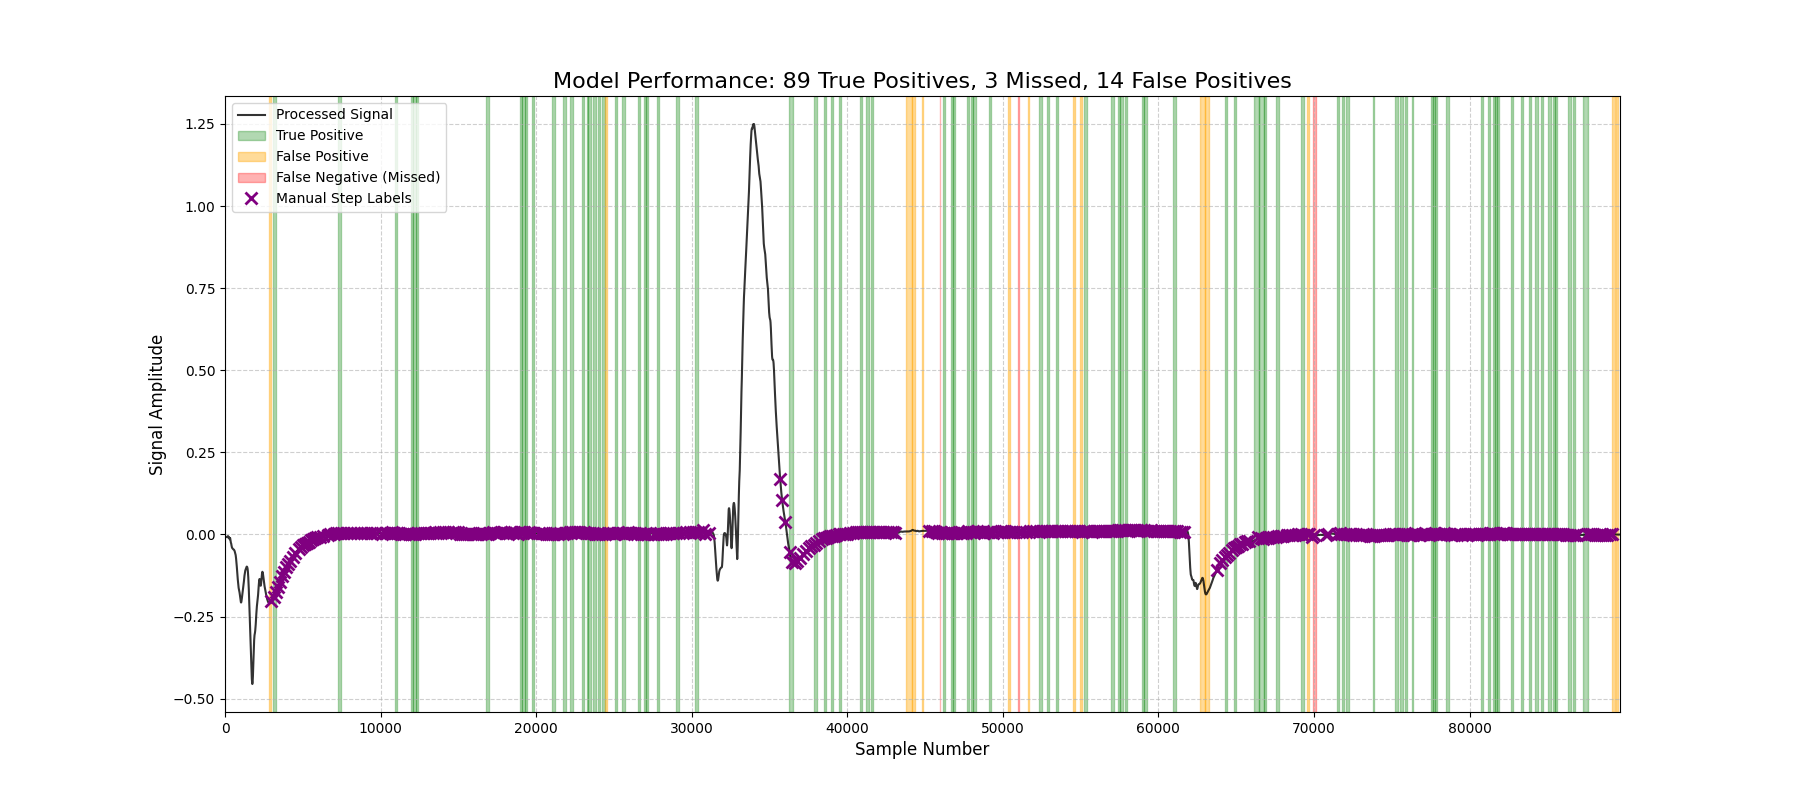

In [27]:
sensor_data['ax_lp'] = exponential_moving_average(sensor_data['ax'] , alpha=0.001)
sensor_data['ay_lp'] = exponential_moving_average(sensor_data['ay'] , alpha=0.001)
sensor_data['az_lp'] = exponential_moving_average(sensor_data['az'] , alpha=0.001)

sensor_data['accel_magnitude_lp'] = np.sqrt(sensor_data['ax_lp']**2 + sensor_data['ay_lp']**2 + sensor_data['az_lp']**2) - 1
sensor_data['accel_magnitude'] = np.sqrt(sensor_data['ax']**2 + sensor_data['ay']**2 + sensor_data['az']**2) - 1

signal = np.array(simple_moving_average(sensor_data['accel_magnitude_lp'], 102))


# =================================================================
# 7. NEW: DETAILED VISUALIZATION OF MODEL PERFORMANCE
# =================================================================
plt.figure(figsize=(18, 8))

# --- Plot the main signal ---
plt.plot(signal, color='black', label='Processed Signal', zorder=2, alpha=0.8)

# --- Plot the results using shaded areas ---
# True Positives (Green)
for i, interval in enumerate(true_positive_intervals):
    label = 'True Positive' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='green', alpha=0.3, label=label, zorder=1)

# False Positives (Orange) - The model said "step" but it wasn't
for i, interval in enumerate(false_positive_intervals):
    label = 'False Positive' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='orange', alpha=0.4, label=label, zorder=1)
    
# False Negatives (Red) - A real step that the model missed
for i, interval in enumerate(false_negative_intervals):
    label = 'False Negative (Missed)' if i == 0 else ""
    plt.axvspan(interval[0], interval[1], color='red', alpha=0.3, label=label, zorder=1)

# --- Plot ground truth for reference ---
plt.plot(manual_steps_list, signal[manual_steps_list], 'x', color='purple', markersize=8, mew=2, label='Manual Step Labels', zorder=5)


# --- Final Touches ---
title = f"Model Performance: {len(true_positive_intervals)} True Positives, {len(false_negative_intervals)} Missed, {len(false_positive_intervals)} False Positives"
plt.title(title, fontsize=16)
plt.xlabel("Sample Number", fontsize=12)
plt.ylabel("Signal Amplitude", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional: Zoom into the area covered by the test set to see details
if len(intervals_test) > 0:
    plot_start = intervals_test[:, 0].min() - 200
    plot_end = intervals_test[:, 1].max() + 200
    plt.xlim(max(0, plot_start), min(len(signal), plot_end))

plt.show()